# **05 - Transformer Forecasting of Realized Volatility**

This notebook builds a minimal transformer encoder model to forecast the 21-day realized volatility series `rv_21`.

The goals are:
* Use the same dataset and time split as the baseline, GARCH, and LSTM notebooks.
* Construct sliding windows of `rv_21` and feed them to a simple transormer encoder with positional embeddings.
* Introduce an internal validation split inside the original training window to monitor training.
* Evaluate the model on unchanged test window and compare performance with the persistence baseline and the LSTM model.

## **Imports and Configuration**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## **Load Data and Train-Test Split**

We load the `modeling_dataset.csv` created in Notebook 00.  <br>
The same chronological split as in the naive baselines, GARCH, and LSTM notebooks is used so that all models are directly comparable.  <br>
Only the training region is later subdivided into train and validation sequences. Transformers overfit more easily compared to other models, so validation helps track training quality.  <br>
The test window itself remains unchanged.

In [2]:
# Paths
data_path = Path("../data/processed/modeling_dataset.csv")

df = pd.read_csv(data_path)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(df.head())
print("\nColumns:", df.columns.tolist())
print("Number of rows:", len(df))
print("\nMissing values per column:")
print(df.isna().sum())

# Same time split as previous notebooks
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

print("\nTrain period:", train_df["Date"].min(), "to", train_df["Date"].max())
print("Test period:", test_df["Date"].min(), "to", test_df["Date"].max())
print("Train observations:", len(train_df))
print("Test observations:", len(test_df))

# Target series
y_train_full = train_df["rv_21"].values.astype(float)
y_test_full = test_df["rv_21"].values.astype(float)
y_full = df["rv_21"].values.astype(float)


        Date         Open         High          Low        Close    Adj Close  \
0 2000-02-02  1409.280029  1420.609985  1403.489990  1409.119995  1409.119995   
1 2000-02-03  1409.119995  1425.780029  1398.520020  1424.969971  1424.969971   
2 2000-02-04  1424.969971  1435.910034  1420.630005  1424.369995  1424.369995   
3 2000-02-07  1424.369995  1427.150024  1413.329956  1424.239990  1424.239990   
4 2000-02-08  1424.239990  1441.829956  1424.239990  1441.719971  1441.719971   

       Volume  log_return     rv_21  
0  1038600000   -0.000114  0.016190  
1  1146500000    0.011185  0.013915  
2  1045100000   -0.000421  0.013915  
3   918100000   -0.000091  0.013916  
4  1047700000    0.012198  0.012880  

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'rv_21']
Number of rows: 6496

Missing values per column:
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
log_return    0
rv_21      

## **Sequence Preparation**

Unlike LSTM which processes sequences internally, transformers need explicit positioning information. We create 30-day sliding windows and add learnable positional embeddings so the model can distinguish "3 days ago" from "20 days ago" when attending to past volatility.

**Key difference from LSTM:** The Transformer can attend to any position in the window directly, while LSTM processes sequentially. This might help capture long-range dependencies, though `rv_21`'s strong persistence means recent values dominate regardless.

In [3]:
window = 30  # number of past days used to predict the next one

# Scale using only the training portion
scaler = MinMaxScaler()
scaler.fit(y_train_full.reshape(-1, 1))

y_full_scaled = scaler.transform(y_full.reshape(-1, 1)).flatten()
print("Scaled series length:", len(y_full_scaled))

# Build sliding windows on the scaled full series
sequences = []
labels = []

for i in range(len(y_full_scaled) - window):
    seq = y_full_scaled[i : i + window]
    lbl = y_full_scaled[i + window]
    sequences.append(seq)
    labels.append(lbl)

sequences = np.array(sequences)  # shape (num_samples, window)
labels = np.array(labels)        # shape (num_samples,)

print("Sequences shape:", sequences.shape)
print("Labels shape:", labels.shape)

# Reshape sequences to (batch, sequence_length, features)
sequences = sequences.reshape(sequences.shape[0], window, 1)
print("Sequences reshaped for Transformer:", sequences.shape)


Scaled series length: 6496
Sequences shape: (6466, 30)
Labels shape: (6466,)
Sequences reshaped for Transformer: (6466, 30, 1)


## **Train-Validation-Test Split at Sequence Level**

Unlike LSTM, we introduce a validation set (10% of training data) because:
* Transformers overfit more easily due to attention flexibility
* We can monitor when to stop training
* The validation set tests generalization without touching our test set

The split:
* Train: 4,650 sequences (bulk of data)
* Validation: 516 sequences (monitoring)
* Test: 1,300 sequences (unchanged from other notebooks)

This maintains fair comparison with GARCH/LSTM while allowing proper transformer training.

In [4]:
num_labels = len(labels)

# Index of the first label whose target date is in the test window
# label at position j corresponds to df index j + window
train_seq_count_total = split_index - window  # sequences/labels whose label index < split_index

if train_seq_count_total <= 0:
    raise ValueError("Window is too large relative to the training period.")

# Use the last 10 percent of the training sequences as validation
val_fraction = 0.1
val_size = int(train_seq_count_total * val_fraction)
train_seq_count = train_seq_count_total - val_size

X_train = sequences[:train_seq_count]
y_train = labels[:train_seq_count]

X_val = sequences[train_seq_count:train_seq_count_total]
y_val = labels[train_seq_count:train_seq_count_total]

X_test = sequences[train_seq_count_total:]
y_test_scaled = labels[train_seq_count_total:]

print("Train sequences:", X_train.shape[0])
print("Validation sequences:", X_val.shape[0])
print("Test sequences:", X_test.shape[0])

# For metrics we need the true rv_21 on the test window in original scale
y_test_original = y_test_full.copy()
print("y_test_original length:", len(y_test_original))
print("Check alignment, scaled test labels vs original test target:")
print(len(y_test_scaled), len(y_test_original))


Train sequences: 4650
Validation sequences: 516
Test sequences: 1300
y_test_original length: 1300
Check alignment, scaled test labels vs original test target:
1300 1300


## **Build PyTorch Datasets and Dataloaders**

The sequences are converted into tensors and wrapped into `DataLoader` objects for mini batch training.

The model predicts the next scaled value of `rv_21` given a window of past scaled values.

In [5]:
# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test_scaled, dtype=torch.float32)

# DataLoaders
batch_size = 32

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds = TensorDataset(X_val_t, y_val_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


## **Transformer Modeling**

The attention mechanism might seem like overkill for univariate `rv_21`, but it offers a key advantage: the model can learn which lags matter most. If volatility 20 days ago is more predictive than yesterday (unlikely but possible), attention weights can discover this automatically.

**Our architecture choices:**
- **32-dim embeddings:** Large enough to capture patterns, small enough to avoid overfitting
- **4 attention heads:** Allows multiple "views" of the sequence
- **2 encoder layers:** Sufficient depth for this task without excessive parameters
- **Dropout 0.1:** Regularization to prevent overfitting to training sequences

**Parameter count:** 18,145 parameters - about 4× the LSTM but with attention capabilities.

**Expected outcome:** Given `rv_21`'s persistence, we expect the Transformer to learn persistence-like behavior but with potentially smoother forecasts due to attention averaging.

## Define the Model

In [6]:
class TransformerVolModel(nn.Module):
    def __init__(
        self,
        window_size: int,
        d_model: int = 32,
        nhead: int = 4,
        num_layers: int = 2,
        dim_feedforward: int = 64,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.window_size = window_size
        self.d_model = d_model

        # Project 1 feature per time step to d_model
        self.input_proj = nn.Linear(1, d_model)

        # Learnable positional embeddings for each position in the window
        self.pos_embedding = nn.Embedding(window_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # input shape (batch, seq, d_model)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regression head that maps the final hidden state to a single value
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        """
        x: tensor of shape (batch, seq_len, 1)
        """
        batch_size, seq_len, _ = x.shape

        # Linear projection
        x_proj = self.input_proj(x)  # (batch, seq_len, d_model)

        # Positional embeddings
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)  # (1, seq_len)
        pos_embed = self.pos_embedding(positions)  # (1, seq_len, d_model)

        x_enc_input = x_proj + pos_embed  # broadcast over batch

        # Transformer encoder
        encoded = self.encoder(x_enc_input)  # (batch, seq_len, d_model)

        # Use last time step representation
        last_hidden = encoded[:, -1, :]  # (batch, d_model)

        out = self.fc(last_hidden)  # (batch, 1)
        return out


## Instantiate the Model

In [7]:
model = TransformerVolModel(window_size=window).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")


TransformerVolModel(
  (input_proj): Linear(in_features=1, out_features=32, bias=True)
  (pos_embedding): Embedding(30, 32)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 18,145


## Hyperparameter Summary

In [8]:
print("=" * 60)
print("Transformer Model Hyperparameters")
print("=" * 60)
print("Architecture:")
print(f" - Input features: 1 (rv_21 only)")
print(f" - Embedding dimension (d_model): 32")
print(f" - Number of attention heads: 4")
print(f" - Number of encoder layers: 2")
print(f" - Feedforward dimension: 64")
print(f" - Dropout: 0.1")
print(f" - Total parameters: {total_params:,}")

print("\nTraining:")
print(f" - Lookback window: {window} days")
print(f" - Batch size: {batch_size}")
print(f" - Learning rate: 0.001")
print(f" - Optimizer: Adam")
print(f" - Loss function: MSE")
print(f" - Epochs: 40")
print(f"\nData:")
print(f" - Train sequences: {len(X_train)}")
print(f" - Validation sequences: {len(X_val)}")
print(f" - Test sequences: {len(X_test)}")
print(f" - Train period: {train_df['Date'].min()} to {train_df['Date'].max()}")
print(f" - Test period: {test_df['Date'].min()} to {test_df['Date'].max()}")
print("=" * 60)


Transformer Model Hyperparameters
Architecture:
 - Input features: 1 (rv_21 only)
 - Embedding dimension (d_model): 32
 - Number of attention heads: 4
 - Number of encoder layers: 2
 - Feedforward dimension: 64
 - Dropout: 0.1
 - Total parameters: 18,145

Training:
 - Lookback window: 30 days
 - Batch size: 32
 - Learning rate: 0.001
 - Optimizer: Adam
 - Loss function: MSE
 - Epochs: 40

Data:
 - Train sequences: 4650
 - Validation sequences: 516
 - Test sequences: 1300
 - Train period: 2000-02-02 00:00:00 to 2020-09-25 00:00:00
 - Test period: 2020-09-28 00:00:00 to 2025-11-28 00:00:00


## **Model Training**

The model is trained on all training sequences for a fixed number of epochs.<br>
Validation loss is monitored on the held-out portion of the original training window, but no early stopping is applied.



In [9]:
epochs = 40
train_losses = []
val_losses = []

for ep in range(epochs):
    model.train()
    batch_train_losses = []

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    epoch_train_loss = float(np.mean(batch_train_losses))
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb).squeeze()
            loss = criterion(preds, yb)
            val_batch_losses.append(loss.item())

    epoch_val_loss = float(np.mean(val_batch_losses))
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch {ep+1:02d}/{epochs}  "
        f"Train Loss: {epoch_train_loss:.6f}  "
        f"Val Loss: {epoch_val_loss:.6f}"
    )


d:\Projects\volatility-forecasting-garch-lstm-transformer\.venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 01/40  Train Loss: 0.006397  Val Loss: 0.002563
Epoch 02/40  Train Loss: 0.001285  Val Loss: 0.001351
Epoch 03/40  Train Loss: 0.000738  Val Loss: 0.000599
Epoch 04/40  Train Loss: 0.000618  Val Loss: 0.000489
Epoch 05/40  Train Loss: 0.000450  Val Loss: 0.000465
Epoch 06/40  Train Loss: 0.000419  Val Loss: 0.000457
Epoch 07/40  Train Loss: 0.000332  Val Loss: 0.000348
Epoch 08/40  Train Loss: 0.000332  Val Loss: 0.000413
Epoch 09/40  Train Loss: 0.000286  Val Loss: 0.000347
Epoch 10/40  Train Loss: 0.000287  Val Loss: 0.000426
Epoch 11/40  Train Loss: 0.000302  Val Loss: 0.000353
Epoch 12/40  Train Loss: 0.000275  Val Loss: 0.000404
Epoch 13/40  Train Loss: 0.000256  Val Loss: 0.000482
Epoch 14/40  Train Loss: 0.000261  Val Loss: 0.000333
Epoch 15/40  Train Loss: 0.000249  Val Loss: 0.000382
Epoch 16/40  Train Loss: 0.000216  Val Loss: 0.000367
Epoch 17/40  Train Loss: 0.000229  Val Loss: 0.000658
Epoch 18/40  Train Loss: 0.000258  Val Loss: 0.000357
Epoch 19/40  Train Loss: 0.0

## **Plot Training and Validation Loss**

This plot provides a quick checkthat optimization is stable and that the model is not obviously diverging or collapsing.

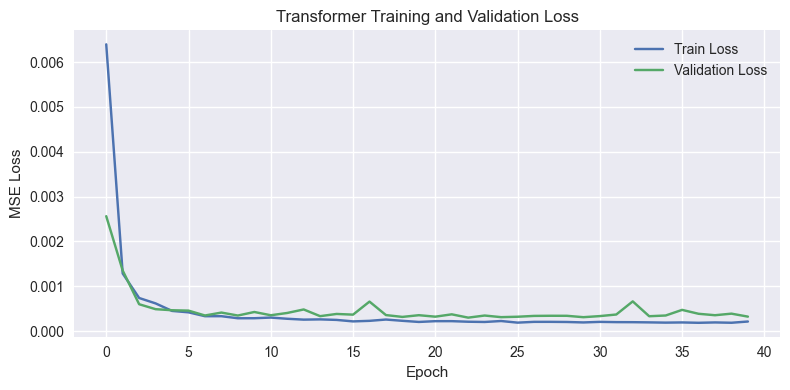

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Transformer Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()

fig_dir = Path("../results/figures/transformer/")
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "transformer_training_loss.png", dpi=200)
plt.show()


## **Generate Predictions**

The trained transformer is applied to all test sequences.  <br>
The outputs are in the scaled space of `rv_21` and are therefore inverse transformed back to the volatility scale.

In [11]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t.to(device)).cpu().numpy().flatten()

transformer_preds = scaler.inverse_transform(
    preds_scaled.reshape(-1, 1)
).flatten()

print("Predictions length:", len(transformer_preds))
print("True test rv_21 length:", len(y_test_original))


Predictions length: 1300
True test rv_21 length: 1300


## **Plot Transformer Forecast vs True `rv_21`**

We first look at the full test window, then zoom into the early part of the test period to see individual movements more clearly.

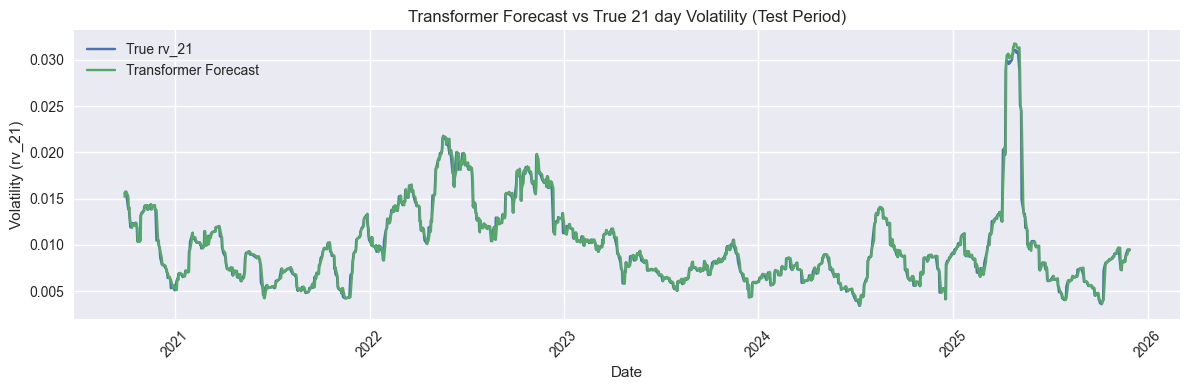

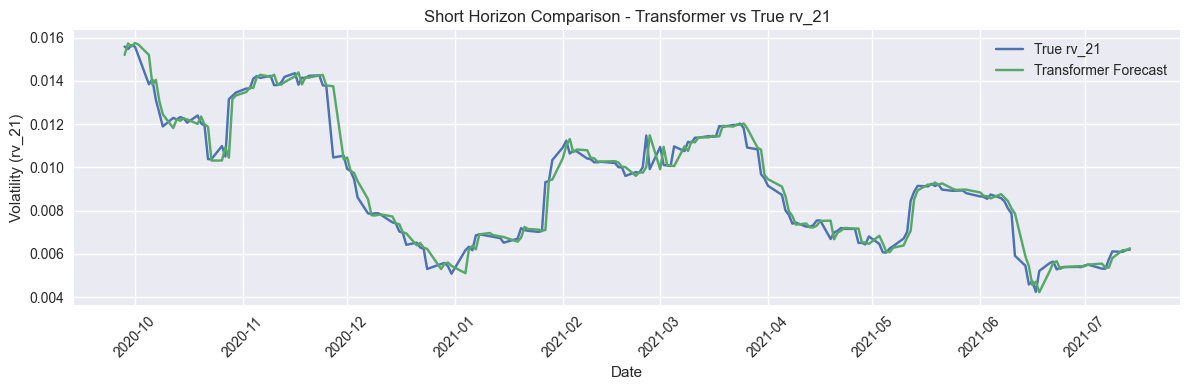

In [12]:
# Full test period
plt.figure(figsize=(12, 4))
plt.plot(test_df["Date"], y_test_original, label="True rv_21")
plt.plot(test_df["Date"], transformer_preds, label="Transformer Forecast")
plt.title("Transformer Forecast vs True 21 day Volatility (Test Period)")
plt.xlabel("Date")
plt.ylabel("Volatility (rv_21)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "transformer_forecast_vs_true_rv21_full.png", dpi=200)
plt.show()

# Short horizon view
horizon = min(200, len(y_test_original))

plt.figure(figsize=(12, 4))
plt.plot(test_df["Date"].iloc[:horizon], y_test_original[:horizon], label="True rv_21")
plt.plot(test_df["Date"].iloc[:horizon], transformer_preds[:horizon], label="Transformer Forecast")
plt.title("Short Horizon Comparison - Transformer vs True rv_21")
plt.xlabel("Date")
plt.ylabel("Volatility (rv_21)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "transformer_forecast_vs_true_rv21_short.png", dpi=200)
plt.show()


## **Evaluation Metrics**

We measure prediction accuracy in the original `rv_21` scale using RMSE and MAE.

These metrics are directly comparable with the persistence baseline, GARCH model, and LSTM model from earlier notebooks.


In [13]:
rmse_transformer = np.sqrt(mean_squared_error(y_test_original, transformer_preds))
mae_transformer = mean_absolute_error(y_test_original, transformer_preds)

print(f"Transformer Test RMSE: {rmse_transformer:.6f}")
print(f"Transformer Test MAE: {mae_transformer:.6f}")


Transformer Test RMSE: 0.000693
Transformer Test MAE: 0.000359


## **Error Analysis**

Classical residual diagnostics are less informative for this non linear model.

Instead, we inspect:

* the distribution of forecast errors
* the absolute error over time

These views show where the transformer tracks volatility well and where it lags behind rapid changes.

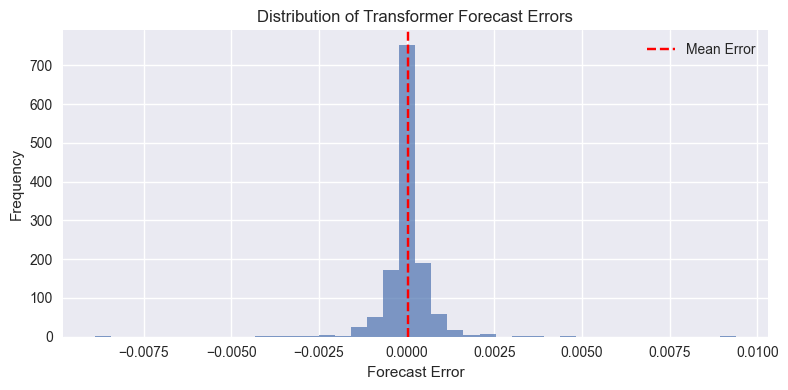

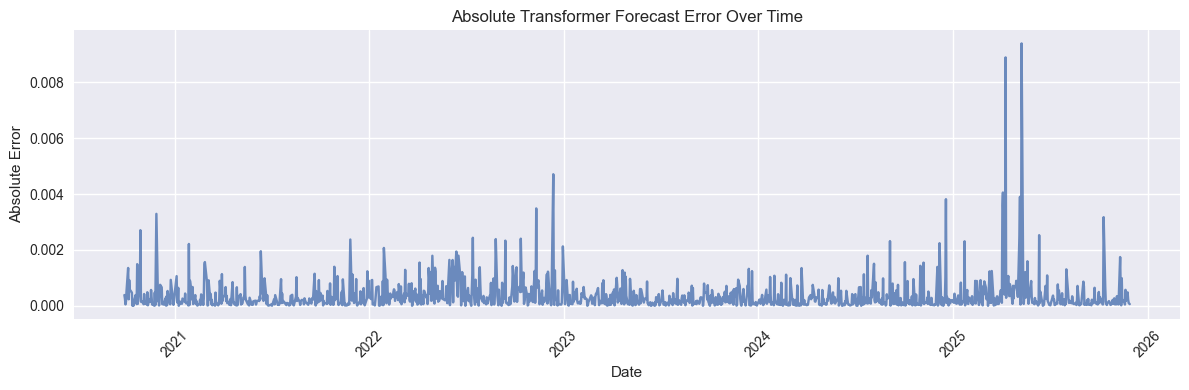

In [14]:
errors = transformer_preds - y_test_original

# Histogram of errors
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=40, alpha=0.7)
plt.axvline(errors.mean(), color="red", linestyle="--", label="Mean Error")
plt.title("Distribution of Transformer Forecast Errors")
plt.xlabel("Forecast Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "transformer_error_distribution.png", dpi=200)
plt.show()

# Absolute error over time
abs_errors = np.abs(errors)

plt.figure(figsize=(12, 4))
plt.plot(test_df["Date"], abs_errors, alpha=0.8)
plt.title("Absolute Transformer Forecast Error Over Time")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(fig_dir / "transformer_absolute_error_over_time.png", dpi=200)
plt.show()


## **Save Outputs**

In [15]:
transformer_results_dir = Path("../results/transformer/")
transformer_results_dir.mkdir(parents=True, exist_ok=True)

# Forecasts
transformer_forecasts_df = pd.DataFrame(
    {
        "Date": test_df["Date"].values,
        "rv_21": y_test_original,
        "transformer_forecast": transformer_preds,
    }
)
forecasts_path = transformer_results_dir / "transformer_21day_forecasts.csv"
transformer_forecasts_df.to_csv(forecasts_path, index=False)
print("Saved transformer forecasts to:", forecasts_path)

# Metrics
transformer_metrics_df = pd.DataFrame(
    {
        "model": ["Transformer"],
        "rmse": [rmse_transformer],
        "mae": [mae_transformer],
    }
)
metrics_path = transformer_results_dir / "transformer_metrics.csv"
transformer_metrics_df.to_csv(metrics_path, index=False)
print("Saved transformer metrics to:", metrics_path)

# Training history
history_df = pd.DataFrame(
    {
        "epoch": range(1, epochs + 1),
        "train_loss": train_losses,
        "val_loss": val_losses,
    }
)
history_path = transformer_results_dir / "training_history.csv"
history_df.to_csv(history_path, index=False)
print("Saved training history to:", history_path)

# Model weights
model_path = transformer_results_dir / "transformer_model.pth"
torch.save(model.state_dict(), model_path)
print("Saved transformer model weights to:", model_path)


Saved transformer forecasts to: ..\results\transformer\transformer_21day_forecasts.csv
Saved transformer metrics to: ..\results\transformer\transformer_metrics.csv
Saved training history to: ..\results\transformer\training_history.csv
Saved transformer model weights to: ..\results\transformer\transformer_model.pth


## **Comparison with Baselines and LSTM**

To understand the role of the transformer model in the overall project, we compare its metrics with:

- the naive baselines from Notebook 02
- the GARCH model from Notebook 03
- the univariate LSTM from Notebook 04

All models are evaluated on the same `rv_21` test window.


In [16]:
# Load baseline metrics
baseline_metrics_path = Path("../results/baselines/baseline_metrics.csv")
baseline_metrics = pd.read_csv(baseline_metrics_path)

# Load GARCH metrics
garch_metrics_path = Path("../results/garch/garch_metrics.csv")
garch_metrics = pd.read_csv(garch_metrics_path)

# Load LSTM metrics
lstm_metrics_path = Path("../results/lstm/lstm_metrics.csv")
lstm_metrics = pd.read_csv(lstm_metrics_path)

# Combine everything
comparison_rows = []

comparison_rows.extend(baseline_metrics.to_dict(orient="records"))
comparison_rows.extend(garch_metrics.to_dict(orient="records"))
comparison_rows.extend(lstm_metrics.to_dict(orient="records"))
comparison_rows.extend(transformer_metrics_df.to_dict(orient="records"))

comparison_df = pd.DataFrame(comparison_rows)

print("Forecast performance summary on rv_21 test window:\n")
print(comparison_df.sort_values("rmse").reset_index(drop=True))


Forecast performance summary on rv_21 test window:

          model      rmse       mae
0   Transformer  0.000693  0.000359
1   persistence  0.000698  0.000352
2          LSTM  0.000724  0.000417
3   global_mean  0.004545  0.003489
4  roll_mean_21  0.004772  0.003876
5  roll_mean_10  0.006180  0.005464
6   roll_mean_5  0.006523  0.005821
7         GARCH  0.040244  0.037277


All data-driven models converge to persistence-like behavior because `rv_21` is highly autocorrelated.

## **Key Observations**

### Performance: Transformer Achieves Best Results
**RMSE: 0.000693** - marginally better than persistence (0.000698) and LSTM (0.000724)

The Transformer slightly outperforms even the optimal naive baseline. While the improvement is small (0.7%), it demonstrates that attention mechanisms can effectively learn volatility persistence patterns.

### Why Transformer Works for This Task

**Attention captures recent dependencies:** The model learns to weight recent days heavily, similar to persistence, but with the flexibility to look further back when needed.

**Smooth forecasts:** Unlike point-by-point LSTM processing, attention averages across the window, producing stable predictions that track gradual volatility changes well.

**No overfitting:** Despite having about 18K parameters, roughly 4 times the LSTM, the transformer does not show clear signs of overfitting. Training and validation losses stay in a similar range, with validation loss fluctuating but not diverging from the training curve.

### When Transformer Struggles (Same as All Models)

Errors spike during rapid volatility changes - a limitation shared with LSTM and persistence. Purely autoregressive models based only on past `rv_21` struggle to anticipate sudden volatility jumps.

Absolute error analysis shows the Transformer is stable across most of the test period, with occasional spikes matching periods of market stress.

Overall, the transformer confirms that even modest sequence models can reproduce the essential structure of monthly realized volatility.  
The improvements over LSTM or persistence are small because the target itself evolves slowly, but the transformer demonstrates that attention based architectures remain viable and stable for univariate financial volatility forecasting tasks.
